In [1]:
import pandas as pd
import numpy as np
from plotly_dataframe import plot 
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from model_selection import rolling_window_validation
from AR import AR
from metrics import metrics
import os
import shutil
from plotly_plt_predictions import plot_predictions
from tqdm import tqdm
from ipywidgets import widgets, interact
import matplotlib.pyplot as plt
from plot_map import choropleth
from IPython.display import clear_output, display

# Forecasting - Food Consumption Score (FCS)

In [2]:
# Load the original data (smoothed data) of the second version of fcs indicator released by wfp.
df = pd.read_csv("../../../Data Sources/Food Consumption Score (FCS)/time-series/Yemen/wfp_fcs-v2-daily-interpolate.csv", header = [0, 1], index_col = 0)
df.index.name = "Datetime"
df.index = pd.to_datetime(df.index)
freq = "D"
df.index.freq = freq
df.columns.names = ["AdminStrata", "Indicator"]
df.head()

AdminStrata,Abyan,Aden,Al Bayda,Al Dhale'e,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amanat Al Asimah,Amran,...,Hadramaut,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'ada,Sana'a,Shabwah,Taizz
Indicator,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,...,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-02,31.158690,16.619519,38.332669,29.194825,20.788151,22.085706,2.892308,16.815145,17.000398,20.446735,...,23.822825,28.361345,25.036668,31.762436,32.596233,54.121774,17.676022,26.917713,16.752289,26.563365
2018-07-03,32.675222,16.370603,43.292084,31.336940,20.692544,23.477196,2.913825,19.833443,17.208166,21.689014,...,23.699881,28.805448,27.102390,32.049499,33.333333,56.722689,17.134560,25.783476,18.257453,29.124005
2018-07-04,33.415597,15.089163,45.128205,33.135157,21.825051,24.864000,2.950408,19.614289,18.070801,25.611124,...,23.103187,30.993706,29.844066,33.106267,36.883683,56.306306,17.454545,25.436047,19.083081,29.427973
2018-07-05,33.531451,15.766521,43.959297,34.554309,21.481693,27.814992,2.247913,19.558566,19.021964,27.922484,...,21.596419,32.905902,29.025363,32.938828,36.897633,56.231003,17.846350,27.421759,20.349533,30.456026
2018-07-06,33.951856,16.870065,44.516521,33.878557,21.076712,28.688245,2.269780,17.608130,19.817567,28.712235,...,20.129084,32.598181,30.692766,33.837934,36.669568,57.324841,18.463057,26.547231,21.107524,31.012517


In [3]:
#plot(fcs, title = "FCS indicator", yaxis = "% of people with poor and borderline FCS", style = "lines")

In [4]:
# Define the desired length of the test set.
TEST = 30
# Define the metric to evaluate the model.
ERROR = "MSE"
# Set boolean parameter to perform an optional grid search.
GRID_SEARCH = True

In [5]:
# Define the training set and the test set.
train = df[:-TEST]  
test = df[-TEST:]

In [6]:
# Create workspace.
dir = "./output"
if not os.path.exists(dir):
    os.makedirs(dir)
else:
    shutil.rmtree(dir)           
    os.makedirs(dir)
    
os.makedirs(dir + "/images")
os.makedirs(dir + "/grid_search")

# Create a txt file where I annotate the above chosen parameters.
with open(dir + "/setting.txt", "w") as f:
    f.write("GRID SEARCH: %s \n" % GRID_SEARCH)
    f.write("TEST: %d \n" % TEST)
    f.write("ERROR: %s \n" % ERROR)

# Autoregressive (AR) model

Autoregression is a time-series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. A regression model, such as linear regression, models an output value based on a linear combination of input values (previous time step in our case). Formally, given a time-series $X = \{x_1, x_2, ..., x_m\}$, with $m$ observations, let's suppose to want to predict the next $x_{m + 1}$ value. The regression model predicts that value following a regression equation where input variables are taken from previous time steps, called *lag variables* $p$. For example, we can predict the value for the next time step ($m + 1$) given the observations at the last two time steps ($m - 1$ and $m - 2$). As a regression model, this would look as follows with $p = 2$:

$$\hat{y} = b_0 + b_1 x_{m - 1} + b_2  x_{m}$$

where $\hat{y}$ is the prediction for the $x_{m + 1}$ value, $b_0$, $b_1$ and $b_2$ are coefficients found by optimizing the model on training data. Because the regression model uses data from the same input variable at previous time steps, it is referred to as an autoregression (regression of self). We could calculate the linear regression model manually using the LinearRegession class in scikit-learn and manually specify the lag input variables to use.

Alternately, the statsmodels library provides an autoregression model where you must specify an appropriate lag value and trains a linear regression model. It is provided in the AutoReg class. We will use this last one.

I search for the best $p$ parameter of each AdminStrata using a grid search.

# Optional grid search

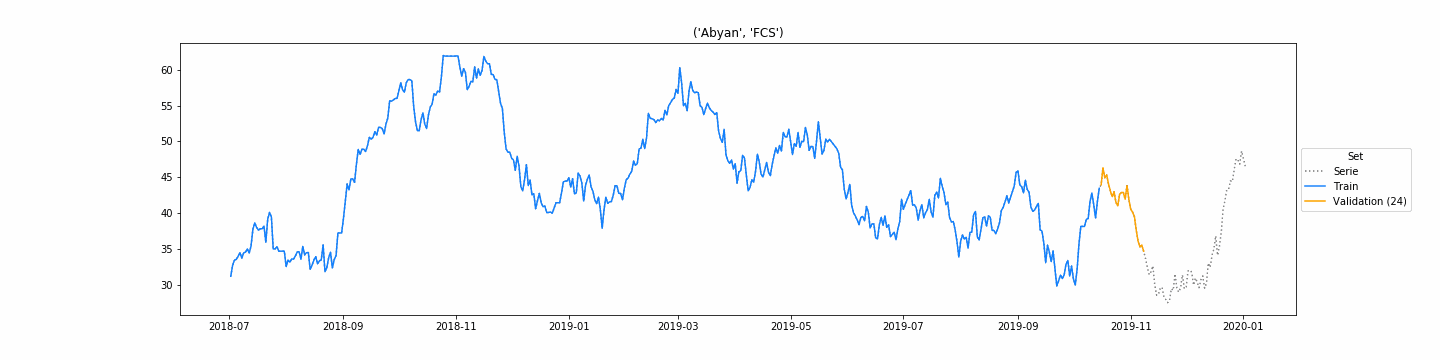

In [8]:
# Define the parameters to grid search.
if GRID_SEARCH:
    validation_type = rolling_window_validation(k_folds = 3, validation_size = 0.05, gap = 0.9, TimeSeriesSplit = False)
    # Show the validation type keeping the first column (time-series).
    _ = validation_type.get_splits(train[train.columns[0]], show = True, path = dir)
    space = {"p": hp.randint("p", 2, 366), 
             "stationary": hp.choice("stationary", [True, False]),
             "bxcx": hp.choice("bxcx", [True, False])
            }
else:
    space = {"p": 1, 
             "stationary": False,
             "bxcx": False
            }

In [9]:
def hyperparameters(space, group):
    adminstrata = group.name
    try:
        losses = list()
        for tr, val in validation_type.get_splits(group, show = False):  
            # Define model.
            model = AR(p = int(space["p"]), h = len(val), stationary = space["stationary"], bxcx = space["bxcx"])
            # Coumpute prediction on this fold.
            pred = model.predict(tr)
            error = metrics(val, pred, ERROR).compute()
            losses.append(error)

        # Compute mean of the fold errors.
        error = np.mean(losses)

        # Recursive save results.
        space["loss"] = error
        df_space = pd.DataFrame(space, index = [0])
        filename = dir + "/grid_search/" + adminstrata + ".csv"
        df_space.to_csv(filename, index = False, header = (not os.path.exists(filename)), mode = "a")
    except:
        error = np.inf

    return {"loss": error, "status": STATUS_OK}

In [13]:
def GridSearch(group):
    adminstrata = group.name
    print("Grid search for adminstrata:", adminstrata)
    # The searching of the best minimum combination of parameters.
    trials = Trials()
    best = fmin(fn = lambda x: hyperparameters(x, group),
                space = space,
                algo = tpe.suggest,
                max_evals = 1000, 
                trials = trials, 
                verbose = True)      
    clear_output(wait = True)
    return best

In [14]:
def NoGridSearch(group):
    adminstrata = group.name
    space["loss"] = 0
    df_space = pd.DataFrame(space, index = [0])
    filename = dir + "/grid_search/" + adminstrata + ".csv"
    df_space.to_csv(filename, index = False)

In [15]:
if GRID_SEARCH:    
    _ = train.groupby(level = 0, axis = 1).apply(GridSearch)
else:
    _ = train.groupby(level = 0, axis = 1).apply(NoGridSearch)

Grid search for adminstrata: Taizz
100%|█████████████████████████████████████████████| 1000/1000 [01:44<00:00,  9.58trial/s, best loss: 9.481775375892957]


# Forecasting

In [16]:
figures = dict()
df_prediction = dict()

In [17]:
def forecast(group):
    adminstrata = group.name
    # Reduce the group dataframe to simple serie.
    serie = group[adminstrata]["FCS"]
    # Load the parameters.
    filename = dir + "/grid_search/" + adminstrata + ".csv"
    params = pd.read_csv(filename)
    best_params = params.loc[params.loss.idxmin()]  
    # Prediction.
    model = AR(p = int(best_params["p"]), h = TEST, stationary = best_params["stationary"], bxcx = best_params["bxcx"])
    predicted = model.predict(serie)
    
    # Define the entire original FCS time-series: train + test.
    original = pd.concat([serie, test[adminstrata]["FCS"]])
    # Plot of the prediction.
    figure = plot_predictions(original, predicted, title = adminstrata, plotly = False, 
                              save = True, dir_to_save = dir + "/images/")
    
    # Store into dictionary.
    figures[adminstrata] = figure
    df_prediction[adminstrata] = predicted
    
    error = metrics(test[adminstrata]["FCS"], predicted, ERROR).compute()
    
    return error

In [18]:
tqdm.pandas()
errors = train.groupby(level = 0, axis = 1).progress_apply(forecast)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  3.66it/s]


In [19]:
errors.mean()

34.21652625991983

In [20]:
def plot_prediction(name):
    fig = figures[name]
    display(fig)

In [21]:
w = widgets.Dropdown(options = df.columns.get_level_values(0).unique(), description = df.columns.get_level_values(0).name, 
                     disabled = False)
p = interact(plot_prediction, name = w)

interactive(children=(Dropdown(description='AdminStrata', options=('Abyan', 'Aden', 'Al Bayda', "Al Dhale'e", …

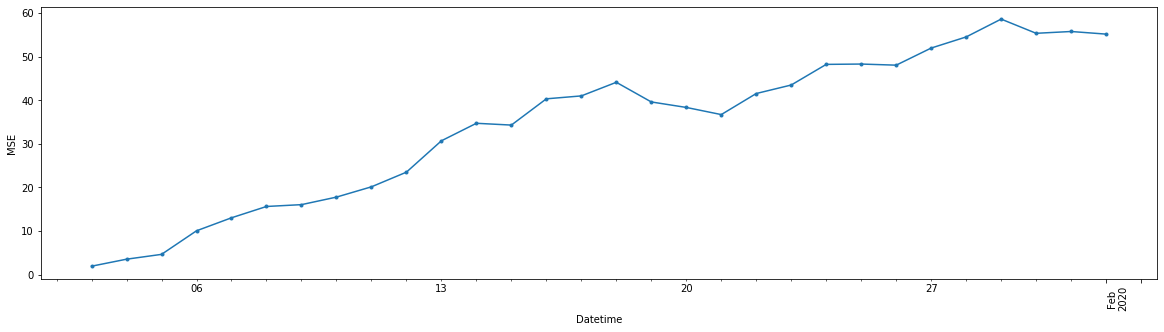

In [22]:
# Plot the mean error in function of the time.
def error_time(serie):
    date = serie.name
    pred_time = pd.DataFrame(df_prediction).transpose()[date]
    error = metrics(serie, pred_time, ERROR).compute()
    return error
    
prediction_time = test.transpose().apply(error_time)

# Show plot.
f = plt.figure(figsize = (20, 5))
prediction_time.plot(ax = f.gca(), style = ".-")
plt.ylabel(ERROR)
plt.xlabel("Datetime")
plt.xticks(rotation = 90)
plt.autoscale()
plt.show()

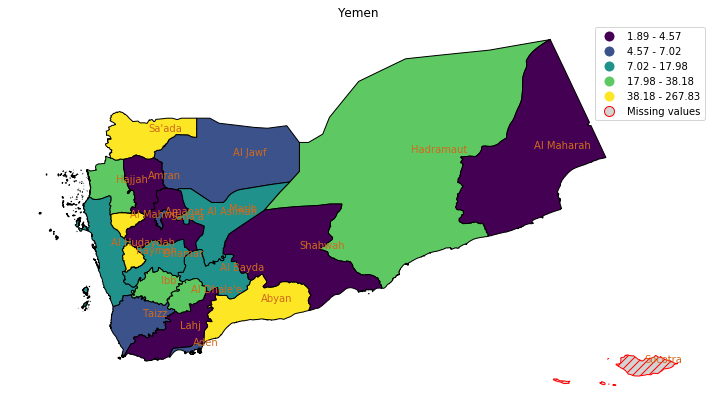

In [23]:
choropleth("Yemen", df.columns.get_level_values(0).unique(), errors, annotation = True, figsize = (15, 7))

In [24]:
# Save the results dataframe.
predictions = pd.DataFrame(df_prediction)
predictions.columns = pd.MultiIndex.from_product([predictions.columns, ["FCS"]])
predictions.columns.names = ["AdminStrata", "Indicator"]

In [25]:
test.to_csv(dir + "/test.csv")
predictions.to_csv(dir + "/AR.csv")